In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pymc3 as pm
import matplotlib.pylab as plt
import theano.tensor as tt
from theano import shared, function
from theano.tensor.shared_randomstreams import RandomStreams
sns.set_style('white')

DATA = '../data/clean/'

Check for the number of available compute cores

In [2]:
import multiprocessing

multiprocessing.cpu_count()

4

## Data import

Line list to extract cases

In [3]:
line_list = pd.read_csv(DATA + 'line_list.csv')
line_list.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
2,1762.0,2015-04-14,KhU,2015-01-04,0.279261,1.0,1.0,0.0,NaN,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
4,6465.0,2015-05-12,UB,2013-12-18,1.314168,1.0,0.0,0.0,NaN,0.0,False,5.0,2015.0


Extract and plot confirmed counts

In [4]:
confirmed_counts = pd.read_csv(DATA + 'confirmed_counts.csv', index_col=0)
confirmed_counts.tail()

,"[0, 1)","[1, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
date_onset,,,,,,,,,,
2016-05-08,318.0,97.0,83.0,119.0,180.0,155.0,152.0,109.0,63.0,41.0
2016-05-22,293.0,79.0,58.0,81.0,131.0,141.0,105.0,87.0,40.0,36.0
2016-06-05,179.0,71.0,39.0,53.0,70.0,62.0,40.0,45.0,20.0,21.0
2016-06-19,77.0,21.0,7.0,21.0,17.0,13.0,3.0,15.0,12.0,7.0
2016-07-03,12.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0


Plot of confirmed counts by age group.

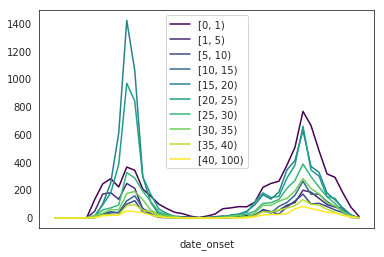

In [5]:
confirmed_counts.plot(cmap='viridis');

In order to account for change in the underlying population, we need the number of births in 2015 and 2016 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Demographics_of_Mongolia#Registered_births_and_deaths))

In [6]:
births = 82130, 79920

We will employ the contact matrix for Mongolia, as estimated by [Prem et al. 2017](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697#sec020)

In [7]:
B_prem = pd.read_csv(DATA + 'mongolia_prem.csv').values[:9, :9]
B_prem

array([[ 4.40123661,  1.76393655,  0.91943738,  0.62449763,  1.04620724,
         1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 1.51664206,  5.57982055,  1.63679975,  0.52656607,  0.37649241,
         0.83552993,  1.0698524 ,  1.04200163,  0.77666399],
       [ 0.56530473,  2.43013564,  9.17372545,  1.33873141,  0.67890573,
         0.56166434,  0.75227034,  0.97884946,  0.97725743],
       [ 0.36238309,  0.73595028,  3.88089151, 12.32915786,  2.48410474,
         1.11449654,  0.79194079,  1.04438411,  1.08448104],
       [ 0.69060422,  0.49460207,  0.65441906,  4.38870495,  6.8744335 ,
         2.87783706,  1.69684851,  1.35746918,  1.11479572],
       [ 1.13165827,  0.59517343,  0.33830222,  1.24692768,  3.31035503,
         4.03747616,  2.29742657,  1.66957878,  1.29603167],
       [ 1.11906529,  1.42978486,  1.12904181,  0.68832499,  1.51871499,
         2.32775238,  2.87889204,  2.1302899 ,  1.51514744],
       [ 1.0230335 ,  1.46318255,  1.28889523,  0.93261004,  0

In [8]:
B_prem.shape

(9, 9)

Expand contact matrix to include infants; treat them the same as 1-4 year-olds.

In [9]:
B_prem_exp = np.zeros((10, 10))
B_prem_exp[1:, 1:] = B_prem.copy()
B_prem_exp[:2, :2] = B_prem_exp[1, 1]
B_prem_exp[0, 2:] = B_prem[0, 1:]
B_prem_exp[2:, 0] = B_prem[1:, 0]
B_prem_exp

array([[ 4.40123661,  4.40123661,  1.76393655,  0.91943738,  0.62449763,
         1.04620724,  1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 4.40123661,  4.40123661,  1.76393655,  0.91943738,  0.62449763,
         1.04620724,  1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 1.51664206,  1.51664206,  5.57982055,  1.63679975,  0.52656607,
         0.37649241,  0.83552993,  1.0698524 ,  1.04200163,  0.77666399],
       [ 0.56530473,  0.56530473,  2.43013564,  9.17372545,  1.33873141,
         0.67890573,  0.56166434,  0.75227034,  0.97884946,  0.97725743],
       [ 0.36238309,  0.36238309,  0.73595028,  3.88089151, 12.32915786,
         2.48410474,  1.11449654,  0.79194079,  1.04438411,  1.08448104],
       [ 0.69060422,  0.69060422,  0.49460207,  0.65441906,  4.38870495,
         6.8744335 ,  2.87783706,  1.69684851,  1.35746918,  1.11479572],
       [ 1.13165827,  1.13165827,  0.59517343,  0.33830222,  1.24692768,
         3.31035503,  4.03747616,  2.29742657

$R_0$ as estimated from this contact matrix

In [10]:
evs = np.linalg.eigvals(B_prem).real
max(evs[np.isreal(evs)])

17.686930739035084

Import the underlying population sizes, by province:

In [11]:
population = pd.read_csv(DATA + '../clean/denominators.csv', index_col=0)
population.head()

,Total,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
Province,,,,,,,,,,,,,,,,
Arkhangai,92896,10440,8360,7883,9249,9469,8207,6856,6824,6294,5498,4643,3266,2202,1237,2468
Bayan-Ulgii,93165,11655,10219,9929,8794,8872,8531,7207,6199,5713,4633,3842,2747,1665,1006,2153
Bayankhongor,79310,9760,7429,6675,7812,7992,7436,6280,5806,5165,4383,3714,2436,1480,1008,1934
Bulgan,60324,6415,5351,4556,5423,5587,4977,4499,4592,4426,4066,3494,2619,1666,877,1776
Gobi-Altai,56698,5953,5392,5046,5778,5631,4837,4401,4345,3994,3389,2730,1974,1064,706,1458


Age classes above 40 will be aggregated into a single group.

In [12]:
pop_classes = population.iloc[:, 1:9].copy()
pop_classes['40+'] = population.iloc[:, 9:].sum(1)
pop_classes.head()

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40+
Province,,,,,,,,,
Arkhangai,10440,8360,7883,9249,9469,8207,6856,6824,25608
Bayan-Ulgii,11655,10219,9929,8794,8872,8531,7207,6199,21759
Bayankhongor,9760,7429,6675,7812,7992,7436,6280,5806,20120
Bulgan,6415,5351,4556,5423,5587,4977,4499,4592,18924
Gobi-Altai,5953,5392,5046,5778,5631,4837,4401,4345,15315


In [13]:
age_group_index = pop_classes.columns.str.strip()
age_group_index

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40+'],
      dtype='object')

In [14]:
pop_classes_total = pop_classes.sum().values

Break out infants from 0-4 group. Will use average of 2015 and 2016 births, and subtract them from 0-4's.

In [16]:
mean_births = int(np.mean(births))
N = [mean_births, pop_classes_total[0] - mean_births]
N.extend(pop_classes_total[1:])
N = np.array(N)

Here is the assumed population size by age group, with infants as their own group.

In [17]:
N

array([  81025,  441650,  418444,  352776,  386296,  427388,  448107,
        379846,  348235, 1264181])

Try to obtain susceptible proportion from coverage history

In [18]:
coverage = pd.read_csv(DATA + 'coverage.csv', index_col=0)

In [19]:
coverage.tail(20)

,MCV1,MCV2,SIA 1994 (M),SIA 1996 (M),SIA 2000 (M),SIA 2007 (M),SIA 2012 (MR)
Age,,,,,,,
19,0.89,0.00,0.0,0.98,0.96,0.00,0.00
18,0.91,0.00,0.0,0.00,0.96,0.97,0.00
17,0.93,0.00,0.0,0.00,0.96,0.97,0.87
16,0.93,0.75,0.0,0.00,0.96,0.97,0.89
15,0.92,0.95,0.0,0.00,0.00,0.97,0.91
14,0.95,0.96,0.0,0.00,0.00,0.97,0.88
13,0.98,0.98,0.0,0.00,0.00,0.97,0.95
12,0.98,0.98,0.0,0.00,0.00,0.97,0.95
11,0.99,0.98,0.0,0.00,0.00,0.97,0.96


In [20]:
age_classes = [0,1,5,10,15,20,25,30,35,40,100]
age_slices = [slice(age_classes[i], age_classes[i+1]) for i in range(len(age_classes)-1)]

In [21]:
n_age_classes = len(age_classes) - 1

In [22]:
efficacy = 0.85

Dependent MCV immunization

In [23]:
immune_MCV1 = coverage.MCV1 * 0.8
immune_MCV2 = (1 - immune_MCV1) * coverage.MCV2 * 0.8

In [24]:
MCV_immunity = immune_MCV2 + immune_MCV1

In [85]:
group_coverage = downsample(coverage[::-1])

Text(0, 0.5, 'Susceptibility')

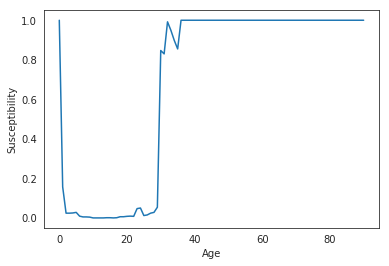

In [25]:
susceptibility = (1 - coverage*efficacy).prod(axis=1).round(3).sort_index()
susceptibility.plot()
plt.ylabel('Susceptibility')

In [26]:
p_susc = susceptibility.groupby(pd.cut(susceptibility.index, age_classes)).mean()

Down-sample susceptibility to age groups.

In [49]:
downsample = lambda x: np.array([x[s].mean() for s in age_slices])
residual_susceptibility = downsample(susceptibility)

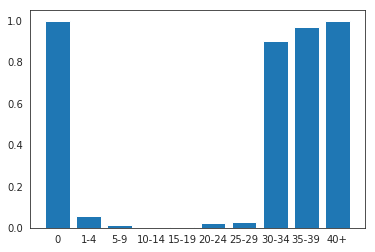

In [28]:
age_labels = ['0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29', 
                    '30-34', '35-39', '40+']
plt.bar(range(len(age_slices)), downsample(susceptibility), 
        tick_label=age_labels);

*These susceptibility rates can't be true given the distribution of cases that were observed!*

### SIA

Create a time x age matrix of SIA vaccinations to account for intervention

In [29]:
sia_2015 = pd.read_csv(DATA + 'sia_2015.csv', index_col=0)
sia_2016 = pd.read_csv(DATA + 'sia_2016.csv', index_col=0)
sia_2015.head()

,0,1-4,5-9
Arkhangai,860,7364,1837
Bayan-Ulgii,1361,9069,1872
Bayankhongor,928,6992,2019
Bulgan,574,4494,1430
Gobi-Altai,494,4490,1276


In [30]:
sia_2015_total = (sia_2015.sum()
                          .reindex(pd.Index(age_labels))
                          .fillna(0)
                          .astype(int))
sia_2015_total

0         34302
1-4      247851
5-9       65532
10-14         0
15-19         0
20-24         0
25-29         0
30-34         0
35-39         0
40+           0
dtype: int64

In [31]:
sia_2016.sum()

15-19     78105
20-24    186022
25-29    230733
30-34     54439
dtype: int64

In [32]:
sia_2016_total = (sia_2016.sum()
                          .reindex(pd.Index(age_labels))
                          .fillna(0)
                          .astype(int))
sia_2016_total

0             0
1-4           0
5-9           0
10-14         0
15-19     78105
20-24    186022
25-29    230733
30-34     54439
35-39         0
40+           0
dtype: int64

In [33]:
sia = pd.DataFrame(index=confirmed_counts.index, columns=pd.Index(age_labels)).fillna(0)

In [34]:
sia.loc['2016-05-22'] = sia_2016_total
sia.loc[['2015-05-24', '2015-06-07', '2015-06-21']] = [sia_2015_total/4,
                                                       sia_2015_total/2,
                                                       sia_2015_total/4]

In [35]:
sia

,0,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40+
date_onset,,,,,,,,,,
2015-01-18,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-29,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-12,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-26,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-05-10,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
sia_vacc = sia.cumsum(0).values

## Stochastic Disease Transmission Model

We will extend a simple SIR disease model, to account for confirmation status, which will be fit using MCMC.

This model fits the series of 2-week infection totals for each age group $a$ as a set of Poisson random variables:

\\[Pr(I_{a}(t) | \lambda_a(t)) = \text{Poisson}(\lambda_a(t)) \\]

Where the age-specific outbreak intensity at time $t$ is modeled as:

\\[\lambda_a(t) = S_a(t-1) \frac{I(t-1)\mathbf{B}}{N_a} \\]

where $S_a(t-1)$ is the number of susceptibles in age group $a$ in the previous time period, $I(t-1)$ an age-specific vector of the number of infected individuals in the previous time period, $\mathbf{B}$ a matrix of transmission coefficients (from Prem et al., specified above), and $N_a$ an estimate of the population of age-$a$ people in Mongolia.

The basic reproductive number $R_0$ was calculated as the largest real-valued eigenvalue of the matrix $\mathbf{B}$. To impose a mild constraint on $R_0$, we applied a Gaussian prior distribution whose 1st and 99th quantiles are 8 and 24, respectively, a reasonable range for a measles outbreak:

### Input data

Cases

In [37]:
I = confirmed_counts.values.astype(int)
I.shape

(39, 10)

In [38]:
I_age = I.sum(0)

In [39]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


In [40]:
clinic_confirmed = lab_samples.query('confirmed==1').dropna(subset=['age_years']).copy()
clinic_confirmed.shape

(5846, 13)

In [41]:
clinic_confirmed['age_group'] = pd.cut(clinic_confirmed.age_years, age_classes, labels=np.arange(len(age_slices)))

In [42]:
clinic_confirmed.dropna(subset=['age_years']).groupby('age_group')['labconfirmed'].mean()

age_group
0    0.768957
1    0.657143
2    0.791489
3    0.503497
4    0.528487
5    0.539967
6    0.533007
7    0.752212
8    0.727273
9    0.372093
Name: labconfirmed, dtype: float64

In [43]:
age_midpoints = np.array([0.5, 3, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 70])

In [45]:
confirmed, age, age_group = clinic_confirmed[['labconfirmed', 'age_years', 'age_group']].values.T

In [46]:
age_group = age_group.astype(int)
age = age.astype(float)

We use a Gaussian random walk to model the variation in confirmation rate across age groups. These functions support the random walk model.

In [47]:
n_knots = 20
knots = np.linspace(age.min(), age.max(), n_knots)

In [48]:
def interpolate(x0, y0, x):
    
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

### Model Specification

In [53]:
with pm.Model() as model:
    
    # Confirmation sub-model
    σ = pm.HalfNormal('σ', 5)
    y = pm.GaussianRandomWalk('y', sd=σ, shape=n_knots)
    α = interpolate(knots, y, age)
    π = pm.invlogit(α)
    
    # Likelihood of observed confirmations, to estimate π
    confirmation = pm.Bernoulli('confirmation', π, observed=confirmed)
    
    # Calculate age group probabilities of confirmation
    α_group = interpolate(knots, y, age_midpoints)
    p_confirm = pm.Deterministic('p_confirm', pm.invlogit(α_group))
    
    # Basic reproduction number centered on the dominant eigenvector of the contact matrix
    R_0 = pm.Normal('R_0', max(evs[np.isreal(evs)]), sd=3.5)
    
    # Initial susceptibles (assume no information)
    S_0 = pm.Uniform('S_0', 0, N, shape=n_age_classes, testval=N*0.8)
    
    # Susceptibles over time, removing individuals vaccinated by SIA
    S = S_0 - shared(sia_vacc) - shared(I.cumsum(axis=0))
    
    # Force of infection
    λ = S * (I.dot(B_prem_exp) / N) + 0.001
    
    # Effective reproductive number
    R_t = pm.Deterministic('R_t', S.sum(1) * R_0 / N.sum())
    
    # Adjust for confirmation bias
    λ_obs = λ / p_confirm
    
    # Infections likelihood
    infections = pm.Poisson('infections', 
                            λ_obs[:-1], 
                            observed=I[1:])



We fit the model using Markov chain Monte Carlo (MCMC) as implemented in PyMC3. This will draw 3000 tuning samples, followed by 1000 samples to be used for inference.

In [55]:
with model:
    
    trace = pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S_0, R_0, y, σ]
Sampling 2 chains: 100%|██████████| 8000/8000 [11:30<00:00, 11.58draws/s]
There were 939 divergences after tuning. Increase `target_accept` or reparameterize.
There were 935 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Convergence check; we want these energy distributions to mostly overlap.

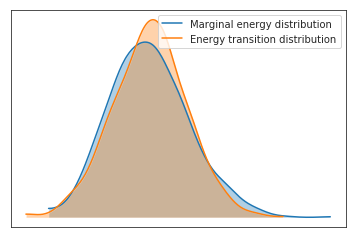

In [56]:
pm.energyplot(trace);

Estimate of initial susceptible pools for each age group.

In [57]:
pm.summary(trace, varnames=['S_0']).round(0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
S_0__0,46015.0,155.0,11.0,45727.0,46313.0,129.0,1.0
S_0__1,251071.0,141.0,10.0,250806.0,251328.0,124.0,1.0
S_0__2,77225.0,508.0,37.0,76234.0,78175.0,78.0,1.0
S_0__3,2711.0,195.0,15.0,2365.0,3096.0,89.0,1.0
S_0__4,85251.0,35.0,3.0,85225.0,85322.0,96.0,1.0
S_0__5,192223.0,120.0,11.0,192144.0,192344.0,30.0,1.0
S_0__6,234251.0,67.0,5.0,234166.0,234378.0,119.0,1.0
S_0__7,57381.0,139.0,10.0,57139.0,57640.0,140.0,1.0
S_0__8,5957.0,513.0,38.0,5022.0,7020.0,125.0,1.0
S_0__9,6264.0,2660.0,204.0,2106.0,11515.0,70.0,1.0


For comparison, estimates without confirmation bias correction:

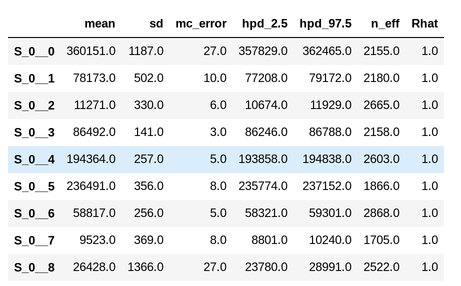

Posterior estimate or $R_0$, which is centered around 18.

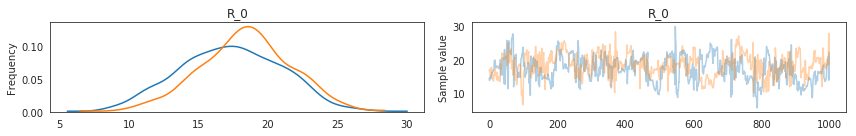

In [59]:
pm.traceplot(trace, varnames=['R_0']);

Trajectory of effective R. Estimate starts at around 4 for the intial outbreak, then drops to just over 2 following the first intervention, then well below one following the second intervention.

GridSpec(1, 2, width_ratios=[3, 1])

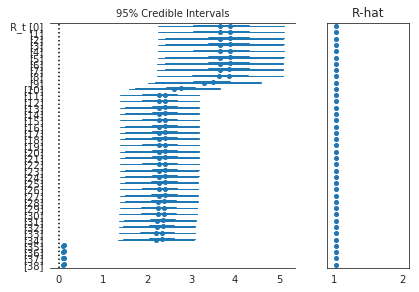

In [60]:
pm.forestplot(trace, varnames=['R_t'])

Prior for vaccine efficacy coefficient

(array([  1.,   1.,   3.,   3.,  17.,  29.,  56., 147., 262., 481.]),
 array([0.47823629, 0.5304097 , 0.58258311, 0.63475652, 0.68692992,
        0.73910333, 0.79127674, 0.84345015, 0.89562356, 0.94779696,
        0.99997037]),
 <a list of 10 Patch objects>)

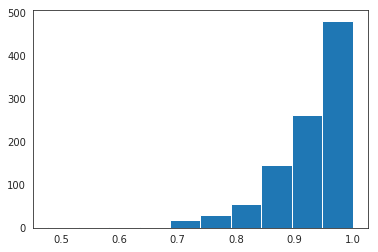

In [81]:
plt.hist(pm.Beta.dist(12, 1).random(size=1000))

### Adding uncertainty in vaccine efficacy

The implementation below generalizes the model to allow for uncertainty in immunization efficacy.

In [115]:
with pm.Model() as uncertain_vacc_model:
    
    # Confirmation sub-model
    σ = pm.HalfNormal('σ', 5)
    y = pm.GaussianRandomWalk('y', sd=σ, shape=n_knots)
    α = interpolate(knots, y, age)
    π = pm.invlogit(α)
        
    confirmation = pm.Bernoulli('confirmation', π, observed=confirmed)
    
    # Calculate age group probabilities of confirmation
    α_group = interpolate(knots, y, age_midpoints)
    p_confirm = pm.Deterministic('p_confirm', pm.invlogit(α_group))
    
    # Basic reproduction number centered on the dominant eigenvector of the contact matrix
    R_0 = pm.Normal('R_0', max(evs[np.isreal(evs)]), sd=3.5)
    
    # Age-specific efficacy of immunization
    p_eff = pm.Beta('p_eff', 12, 1, shape=n_age_classes, testval=np.ones(n_age_classes)*0.1)
    # Susceptibility prior to outbreaks
    susceptibility = tt.prod(1 - group_coverage.T*p_eff, axis=0)
    # Initial susceptibles
    S_0 = pm.Deterministic('S_0', N * susceptibility)
    
    # Setting efficacy to a constant
    p_vacc = efficacy
    
    # Susceptibles over time, removing individuals vaccinated by SIA
    S = S_0 - sia_vacc*p_vacc - shared(I.cumsum(axis=0))
    
    # Force of infection
    λ = S * (I.dot(B_prem_exp) / N) + 0.001
    
    # Effective reproductive number
    R_t = pm.Deterministic('R_t', S.sum(1) * R_0 / N.sum())
    
    # Adjust for confirmation bias
    λ_apparent = λ / p_confirm
    
    # Infections likelihood
    infections = pm.Poisson('infections', λ_apparent[:-1], observed=I[1:])



In [117]:
with uncertain_vacc_model:
    
    unc_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_eff, R_0, y, σ]
Sampling 2 chains: 100%|██████████| 6000/6000 [04:01<00:00, 24.87draws/s]


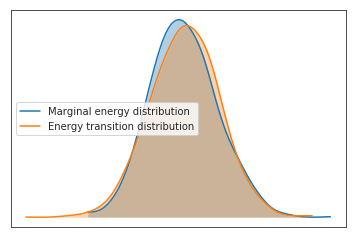

In [118]:
pm.energyplot(unc_trace);

In [74]:
if 'p_vacc_interval__' in [v.name for v in uncertain_vacc_model.free_RVs]:
    pm.forestplot(unc_trace, varnames=['p_vacc'], ylabels=age_labels, rhat=False)

However, this model estimates $R_e$ values that are too high.

GridSpec(1, 2, width_ratios=[3, 1])

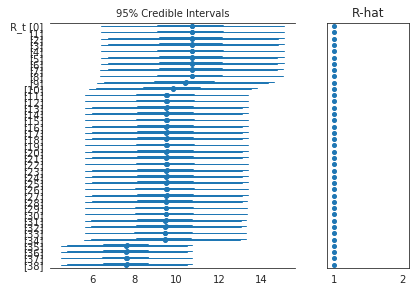

In [119]:
pm.forestplot(unc_trace, varnames=['R_t'])

Here are the age-specific estimates of vaccine efficacy.

GridSpec(1, 1)

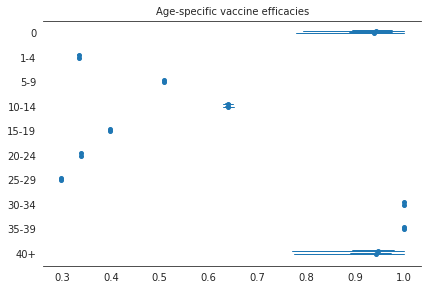

In [122]:
pm.forestplot(unc_trace, varnames=['p_eff'], ylabels=age_labels, 
              rhat=False, main='Age-specific vaccine efficacies')